# Библиотеки

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder

# Загрузка данных

In [ ]:
df = pd.read_csv('data/WORK_bank_data_train.csv', delimiter=';')
df.head()

,ID,Age,Ind_Household,Age_group,District,Region,Lifetime,Income,Segment,Ind_deposit,...,Ind_salary,trans_6_month,trans_9_month,trans_12_month,amont_trans,amont_day_from,trans_3_month,Gender,Target1,Target2
0,1200000001,51.0,No,middle,02,Midlands,3.0,53,Platinum,No,...,No,2026.27,2964.23,4140.91,3,21,910.02,F,No,No
1,1200000002,47.0,No,middle,34,Midlands,2.0,51,Gold,No,...,No,2033.14,2969.30,4202.63,5,14,977.80,U,No,No
2,1200000003,45.0,No,middle,17,North,6.0,50,Silver,No,...,No,2085.68,3080.13,4277.45,11,16,1001.54,M,No,No
3,1200000004,78.0,No,senior,49,Midlands,12.0,52,Platinum,Yes,...,No,2026.58,3001.34,4105.54,3,15,980.78,F,No,No
4,1200000005,57.0,No,middle,19,South East,8.0,52,Silver,Yes,...,No,2142.23,3188.19,4401.98,2,26,1003.68,F,Yes,No


In [6]:
df['Age']

0         51.0
1         47.0
2         45.0
3         78.0
4         57.0
          ... 
985472     NaN
985473    63.0
985474    68.0
985475    45.0
985476    71.0
Name: Age, Length: 985477, dtype: float64

# EDA

## Анализ пропусков

In [4]:
import pandas as pd

def describe_dataframe(df):
    summary = pd.DataFrame({
        'Column': df.columns,
        'dtype': [df[col].dtype for col in df.columns],
        'Unique': [df[col].nunique() for col in df.columns],
        '%unique': [round(df[col].nunique() / len(df) * 100, 2) for col in df.columns],
        'Zero': [(df[col] == 0).sum() for col in df.columns],
        '%zero': [round((df[col] == 0).sum() / len(df) * 100, 2) for col in df.columns],
        'Null': [df[col].isnull().sum() for col in df.columns],
        '%null': [round(df[col].isnull().mean() * 100, 2) for col in df.columns],
    })
    return summary


summary_table = describe_dataframe(df)

summary_table


,Column,dtype,Unique,%unique,Zero,%zero,Null,%null
0,ID,int64,985477,100.00,0,0.00,0,0.00
1,Age,float64,62,0.01,0,0.00,66958,6.79
2,Ind_Household,object,2,0.00,0,0.00,0,0.00
3,Age_group,object,4,0.00,0,0.00,0,0.00
4,District,object,56,0.01,0,0.00,0,0.00
5,Region,object,6,0.00,0,0.00,0,0.00
6,Lifetime,float64,39,0.00,2110,0.21,12608,1.28
7,Income,int64,51,0.01,0,0.00,0,0.00
8,Segment,object,4,0.00,0,0.00,0,0.00
9,Ind_deposit,object,2,0.00,0,0.00,0,0.00


Пропущенные значения есть только в колонках age и lifetime. Обе колонки - численные переменные, а пропущенных значений относительно немного, поэтому заполним их медианой соответствующего столбца. Колонка Age_group, скорее всего, зависит от колонки Age, а значит будет иметь большую корреляцию и затруднит последующую кластеризацию. Исследуем ее отдельно и, при необходимости, удалим.

Так же можно заметить, что в поле Gender имеется три уникальных значения. Это идет в разрез с законодательством РФ, так что это поле надо будет исследовать подробнее.

In [5]:
df = df.drop(columns=['ID'])

## Заполнение пропусков

In [8]:
df['Lifetime'] = df['Lifetime'].fillna(df['Lifetime'].median())
mask_known = df['Age'].notna()

# 2. Готовим X и y для обучения модели
X = df[['Lifetime']]
y = df['Age']

# 3. Обучаем модель на тех записях, где возраст известен
model = LinearRegression()
model.fit(X[mask_known], y[mask_known])

# 4. Предсказываем возраст для записей с пропущенным Age
mask_unknown = ~mask_known
predicted_ages = model.predict(X[mask_unknown])

# 5. Заполняем пропуски предсказанными значениями
df.loc[mask_unknown, 'Age'] = predicted_ages

## Исследование подозрительных признаков

### Age_group

<Axes: xlabel='count', ylabel='Age_group'>

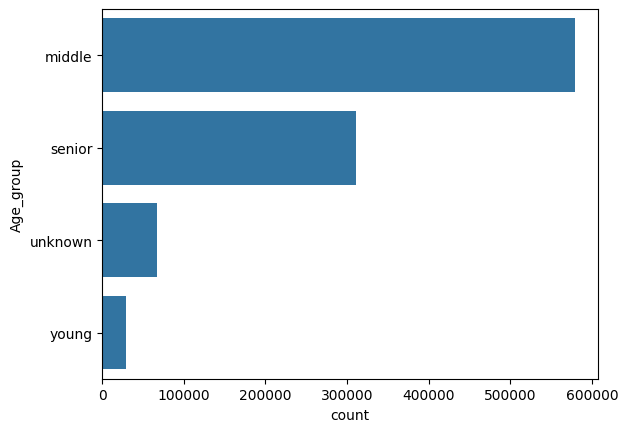

In [9]:
sns.countplot(df['Age_group'])

<Axes: xlabel='Age_group', ylabel='Age'>

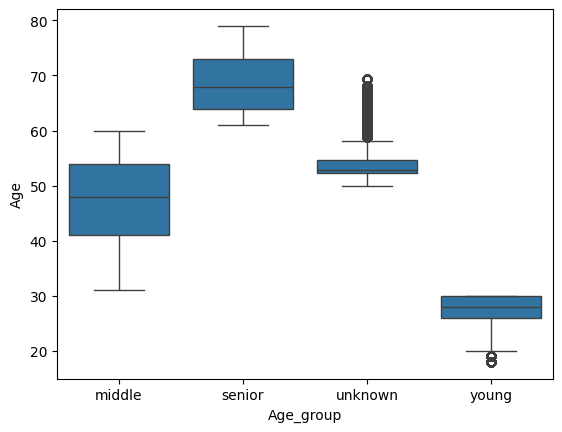

In [10]:
sns.boxplot(x=df['Age_group'], y=df['Age'])

Как и следовало ожидать, колонка, можно сказать, линейно зависит от Age. К тому же, не до конца ясно, следует ли относить тех, кого заполнили медианой, к какой либо из групп. Данную колонку удалим.

In [11]:
df = df.drop(columns=['Age_group'])

### Gender

<Axes: xlabel='count', ylabel='Gender'>

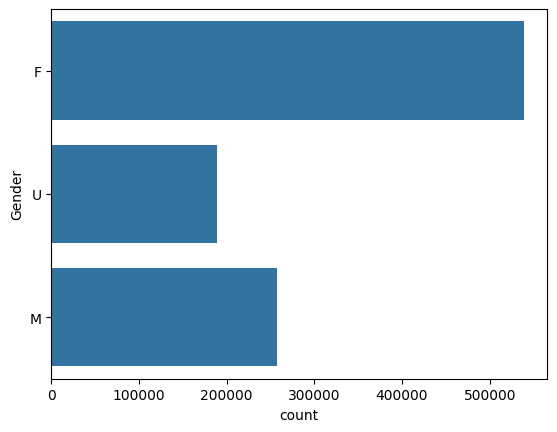

In [10]:
sns.countplot(df['Gender'])

## Исследование признаков

In [12]:
num_cols = ['Age', 'Lifetime', 'trans_3_month', 'trans_6_month', 'trans_9_month', 'trans_12_month', 'Income', 'amont_trans', 'amont_day_from']
cat_cols = ['Ind_household', 'District', 'Region', 'Segment', 'Ind_deposit', 'Ind_email', 'Ind_phone', 'Ind_salary', 'Gender']

### Числовые признаки

In [13]:
df[num_cols].describe()

,Age,Lifetime,trans_3_month,trans_6_month,trans_9_month,trans_12_month,Income,amont_trans,amont_day_from
count,985477.000000,985477.000000,985477.000000,985477.000000,985477.000000,985477.000000,985477.000000,985477.000000,985477.000000
mean,53.786927,6.542326,952.514236,2049.942713,3069.964536,4189.979401,50.356128,7.240207,19.741893
std,12.758618,4.628671,48.247139,70.712709,86.610431,100.020678,5.440736,3.034947,7.014321
min,18.000000,0.000000,716.490000,1668.770000,2624.090000,3698.920000,25.000000,1.000000,10.000000
25%,45.000000,4.000000,920.520000,2002.260000,3011.540000,4122.480000,47.000000,5.000000,15.000000
50%,53.468081,5.000000,952.020000,2050.020000,3069.910000,4190.000000,50.000000,7.000000,16.000000
75%,64.000000,8.000000,984.530000,2097.610000,3128.470000,4257.490000,54.000000,9.000000,25.000000
max,79.000000,39.000000,1174.030000,2370.870000,3468.300000,4684.880000,75.000000,49.000000,42.000000


<Axes: xlabel='Age', ylabel='Count'>

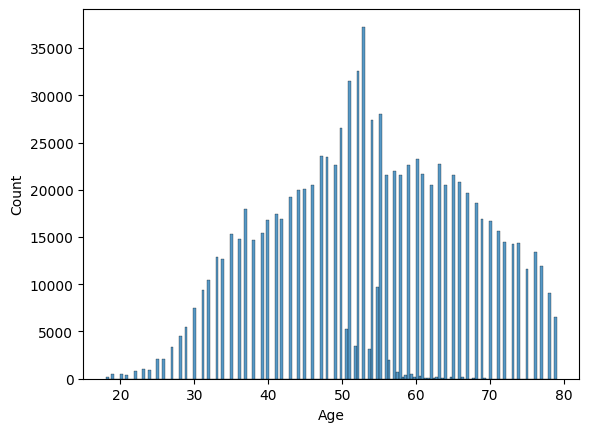

In [14]:
sns.histplot(df['Age'])

<Axes: xlabel='Lifetime', ylabel='Count'>

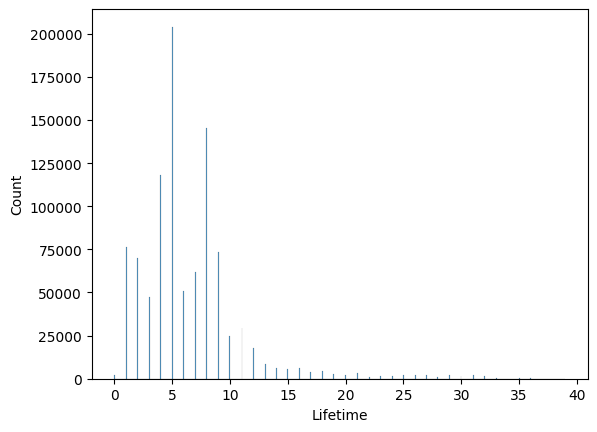

In [15]:
sns.histplot(df['Lifetime'])

Можно заметить, что большая часть клиентов - старше 45. К тому же большинство пользуется банком не дольше 10 лет

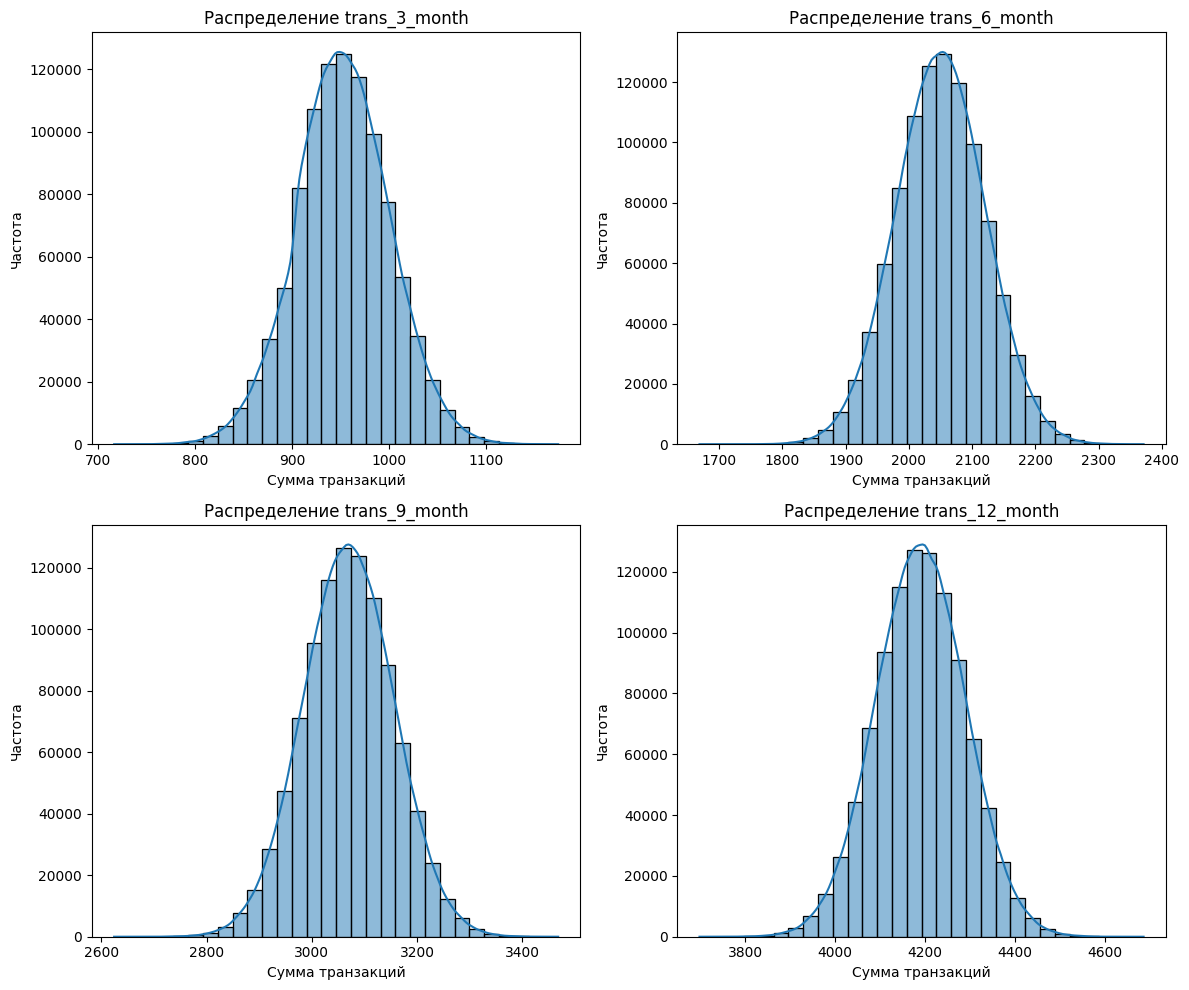

In [16]:
columns = ['trans_3_month', 'trans_6_month', 'trans_9_month', 'trans_12_month']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for i, col in enumerate(columns):
    row = i // 2
    pos = i % 2
    ax = axes[row, pos]

    sns.histplot(data=df, x=col, ax=ax, kde=True, bins=30)
    ax.set_title(f'Распределение {col}')
    ax.set_xlabel('Сумма транзакций')
    ax.set_ylabel('Частота')

plt.tight_layout()
plt.show()

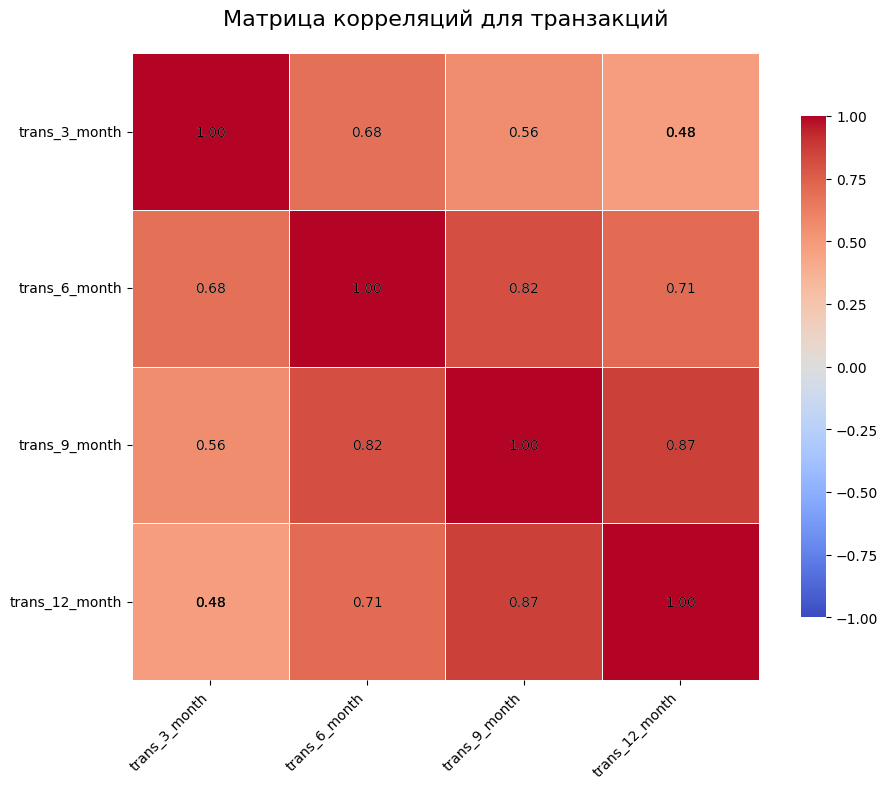

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Выбираем нужные столбцы
cols = ['trans_3_month', 'trans_6_month', 'trans_9_month', 'trans_12_month']
corr_data = df[cols]

# Вычисляем матрицу корреляций
corr_matrix = corr_data.corr()

# Создаем тепловую карту
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            linewidths=0.5,
            square=True,
            cbar_kws={"shrink": 0.8})

# Настраиваем внешний вид
plt.title('Матрица корреляций для транзакций', pad=20, fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Добавляем значения корреляции в ячейки
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        plt.text(j+0.5, i+0.5, f'{corr_matrix.iloc[i, j]:.2f}',
                 ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

Очевидно, что все 4 столбца оставлять смысла мало - они имеют высокую корреляцию и будут мешать друг другу. Оставим только сумму транзакци за 3 месяца, как показатель недавней активности и за 12 месяцев, как показатель общей активности

In [18]:
df = df.drop(columns=['trans_9_month', 'trans_6_month'])

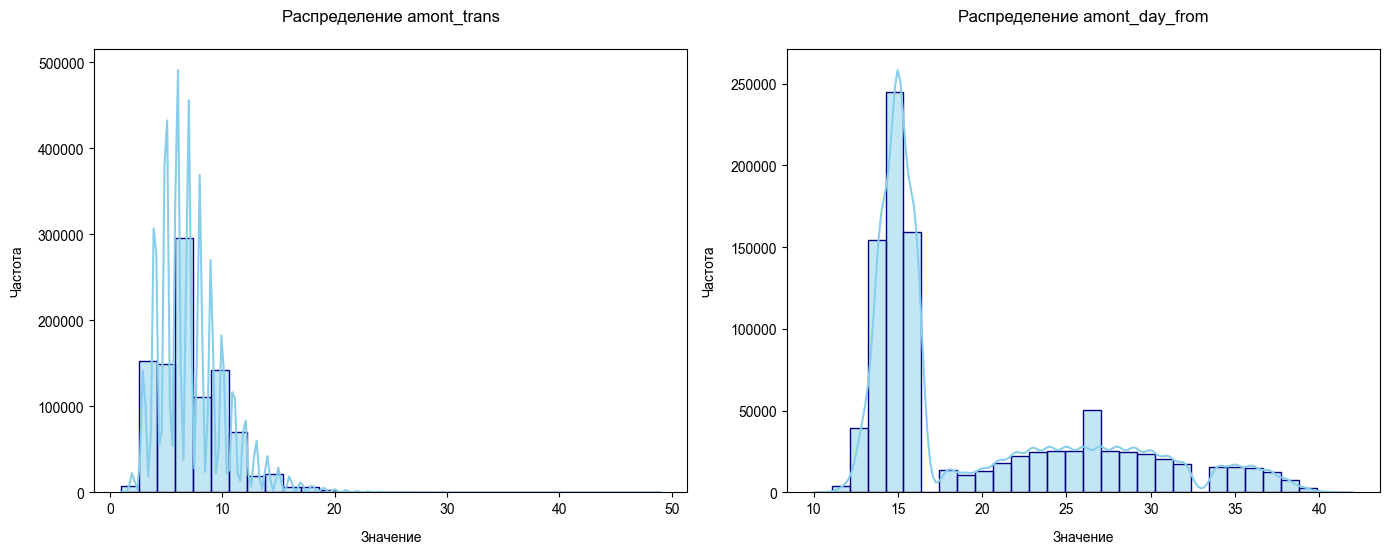

In [19]:
columns = ['amont_trans', 'amont_day_from']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.set_style("whitegrid")

for i, col in enumerate(columns):
    ax = axes[i]
    
    sns.histplot(data=df, 
                 x=col, 
                 ax=ax, 
                 kde=True,
                 bins=30,
                 color='skyblue',
                 edgecolor='navy')
    
    ax.set_title(f'Распределение {col}', pad=20)
    ax.set_xlabel('Значение', labelpad=10)
    ax.set_ylabel('Частота', labelpad=10)
    

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

<Axes: xlabel='Income', ylabel='Count'>

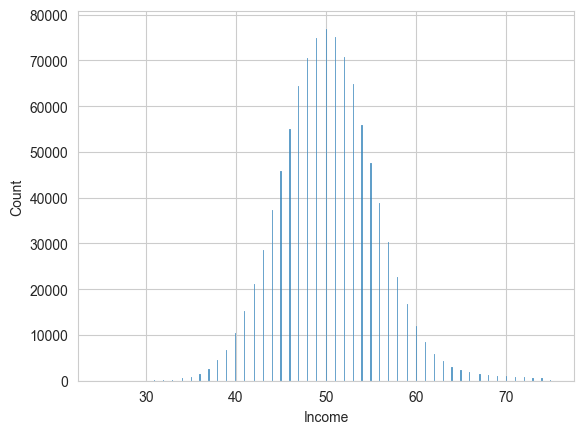

In [20]:
sns.histplot(df['Income'])

К суммам транзакций и доходу будем применять standaed_scaler - их значения распределены почти нормально. К остальным используем robust_scaler, так как имеются незначительные выбросы

## Категориальные признаки

Сразу заметим, что переменная District имеет высокую кардинальность и плотно связана с Region. От нее будет больше вреда, чем пользы, поэтому удалим ее

In [21]:
df = df.drop(columns=['District'])

In [22]:
cat_cols

['Ind_household',
 'District',
 'Region',
 'Segment',
 'Ind_deposit',
 'Ind_email',
 'Ind_phone',
 'Ind_salary',
 'Gender']

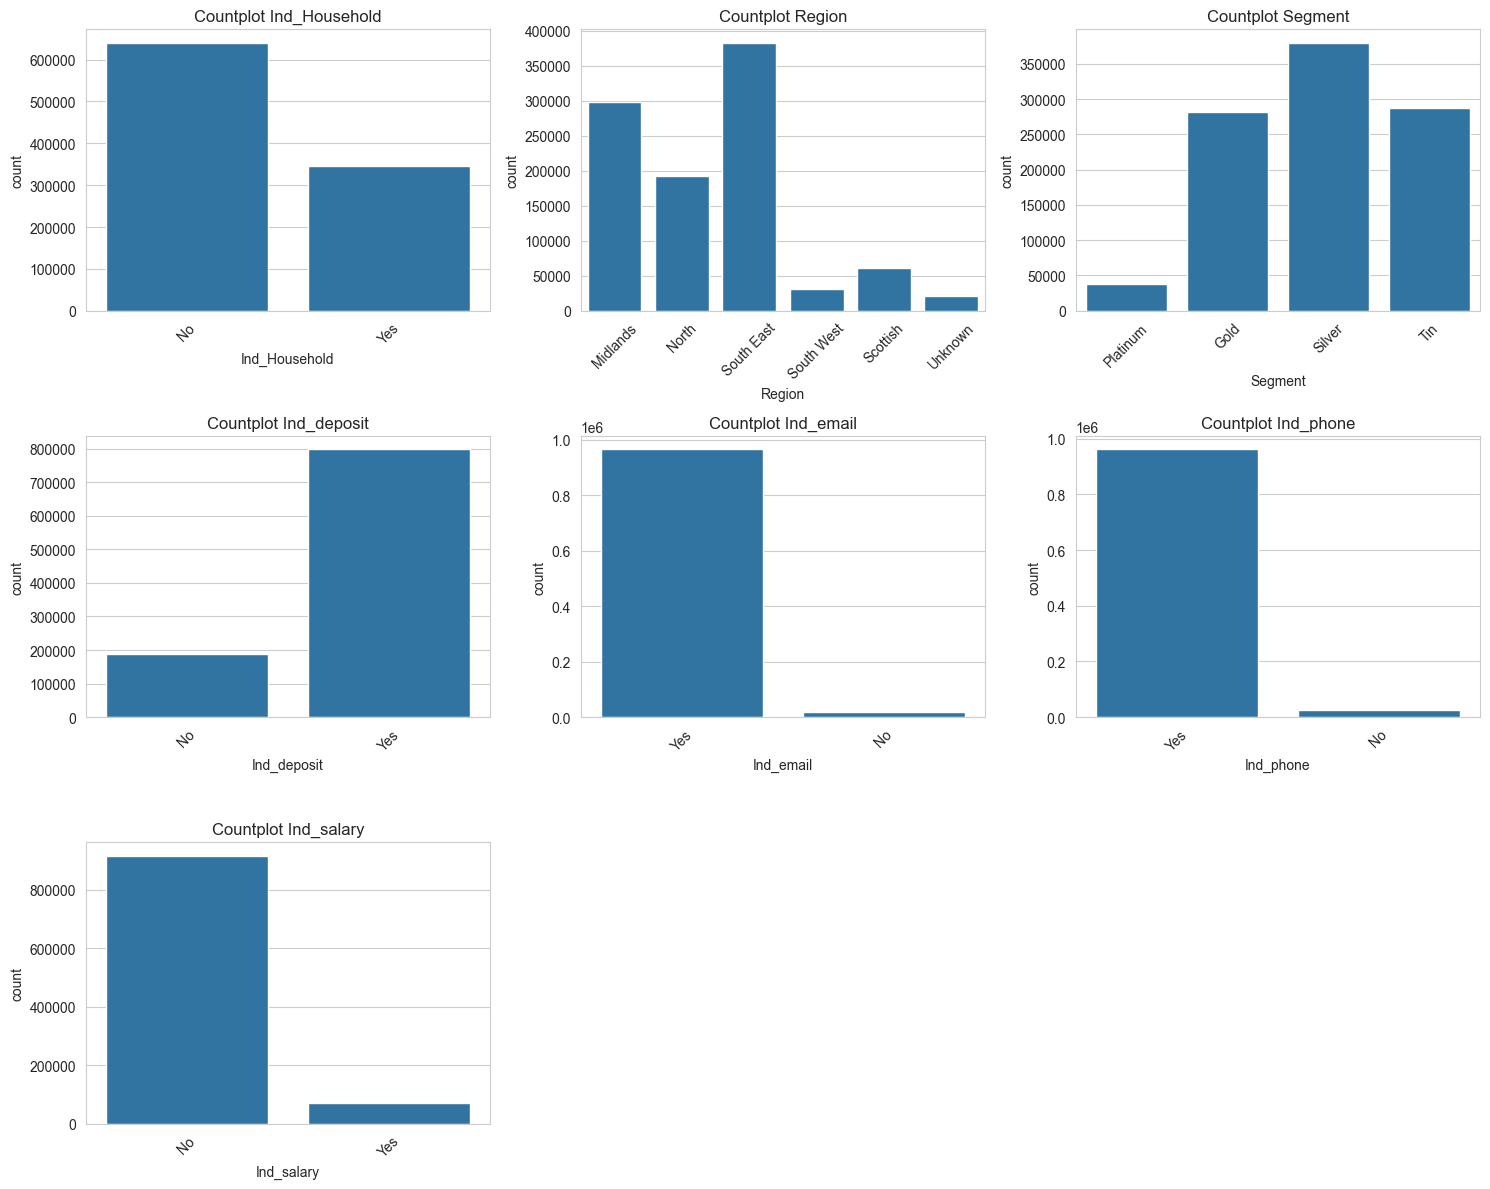

In [22]:
cols = ['Ind_Household', 'Region', 'Segment', 'Ind_deposit', 
        'Ind_email', 'Ind_phone', 'Ind_salary']

plt.figure(figsize=(15, 12))
for i, col in enumerate(cols):
    plt.subplot(3, 3, i+1)
    sns.countplot(data=df, x=col)
    plt.title(f'Countplot {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Первым делом обратим внимание на наличие имейла и телефона. Вероятно, если у пользователя нет имейли, он не ответит на коммуникацию по имейлу

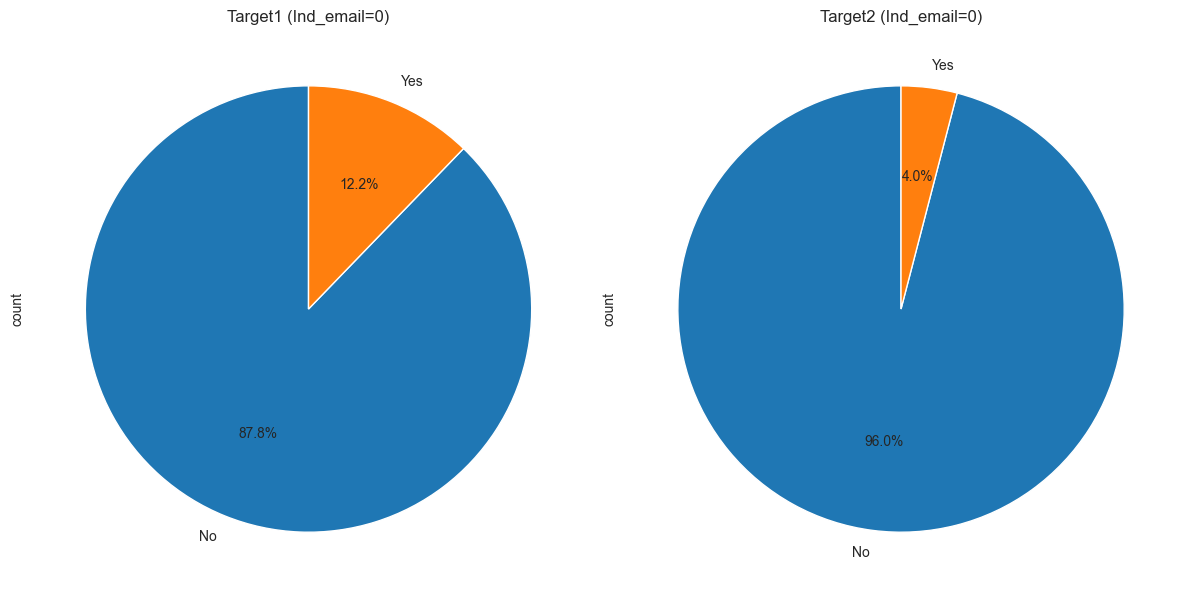

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

df_filtered = df[df['Ind_email'] == 'No']

df_filtered['Target1'].value_counts().plot.pie(ax=axes[0], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Target1 (Ind_email=0)')

df_filtered['Target2'].value_counts().plot.pie(ax=axes[1], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Target2 (Ind_email=0)')

plt.tight_layout()
plt.show()

Не совсем понятно, как такое возможно. Скорее всего - это ошибка, удалим клиентов, которые не имеют e-mail, но откликнулся на коммуникацию через него.

In [24]:
df = df[~((df['Ind_email'] == 'No') & (df['Target1'] == 'Yes'))]

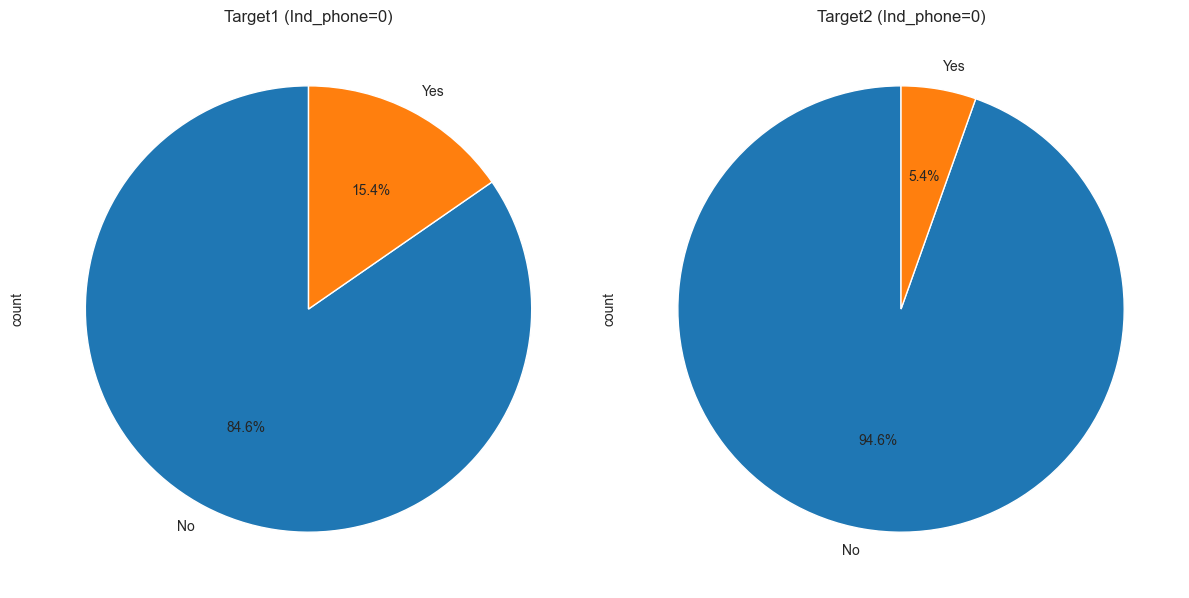

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

df_filtered = df[df['Ind_phone'] == 'No']

df_filtered['Target1'].value_counts().plot.pie(ax=axes[0], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Target1 (Ind_phone=0)')

df_filtered['Target2'].value_counts().plot.pie(ax=axes[1], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Target2 (Ind_phone=0)')

plt.tight_layout()
plt.show()

Аналогично

In [26]:
df = df[~((df['Ind_phone'] == 'No') & (df['Target2'] == 'Yes'))]

In [28]:
df.shape

(792942, 17)

In [27]:
df.head()

,Age,Ind_Household,Region,Lifetime,Income,Segment,Ind_deposit,Ind_email,Ind_phone,Ind_salary,trans_12_month,amont_trans,amont_day_from,trans_3_month,Gender,Target1,Target2
0,51.0,No,Midlands,3.0,53,Platinum,No,Yes,Yes,No,4140.91,3,21,910.02,F,No,No
1,47.0,No,Midlands,2.0,51,Gold,No,Yes,Yes,No,4202.63,5,14,977.80,U,No,No
2,45.0,No,North,6.0,50,Silver,No,Yes,Yes,No,4277.45,11,16,1001.54,M,No,No
3,78.0,No,Midlands,12.0,52,Platinum,Yes,Yes,Yes,No,4105.54,3,15,980.78,F,No,No
4,57.0,No,South East,8.0,52,Silver,Yes,Yes,Yes,No,4401.98,2,26,1003.68,F,Yes,No


In [ ]:
df.to_csv('processed_data.csv')